<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Failure_analysis_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Failure Analysis
### The best performing model: Histogram Gradient Boosting Regression Trees
- The primary focus of this notebook is to perform failure analysis.
- Since our dataset was relatively small considering the diversity of the word vector feature values in the n-dimensional featue space, the best value of the quality of fit we observed was only 37% after we leveraged cross validation along with grid search.
- That being said, Our failure analysis would be more like a success analysis to try and observe what we got right and why we think the model was able to pick that signal up.

In [14]:
!gdown 1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN 
!gdown 1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N 
!gdown 1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
!gdown 12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs

!gdown 1Nwp22QXlSRyczKxC_siWZQ10qm0WVKON

Downloading...
From: https://drive.google.com/uc?id=1PTaSiunxWhwkHxKf5v4G3oPbAXzvGqKN
To: /content/train_X.csv
100% 39.6M/39.6M [00:00<00:00, 129MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1v8rbzAcb_cAw7kwShlGyEuAUw2Ja006N
To: /content/train_y.csv
100% 733k/733k [00:00<00:00, 93.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1porOGWPwFdydbXbQQmveCPvAT1lvO8RC
To: /content/test_X.csv
100% 9.92M/9.92M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=12uI3sXRLJzEwPx05D7tZD5g7DRAcAcFs
To: /content/test_y.csv
100% 183k/183k [00:00<00:00, 75.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nwp22QXlSRyczKxC_siWZQ10qm0WVKON
To: /content/model.sav
100% 749k/749k [00:00<00:00, 121MB/s]


In [153]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pylab as pl

import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from matplotlib import ticker

import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.simplefilter(action='ignore')

In [180]:
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

In [5]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-wiki-gigaword-50')

nltk.download('punkt')
nltk.download('stopwords')

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [98]:
train_X = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")

test_X_ = pd.read_csv("test_X.csv")
test_y = pd.read_csv("test_y.csv")

In [99]:
test_X_

,publishedDayNum,log_duration_secs,len_title,title_1,title_2,title_3,title_4,title_5,title_6,title_7,...,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50,definition,topicLabel
0,55,6.448889,11,-0.067034,0.738506,0.354534,0.585256,0.500022,0.182586,0.032060,...,-0.288240,0.040508,-0.351104,0.022336,0.155882,-0.418398,0.254494,1.296076,hd,cooking
1,251,6.972606,7,-0.221372,0.771232,0.380841,0.853690,0.404392,0.200614,0.332160,...,-0.147374,-0.202466,-0.476051,-0.034336,0.299940,-0.610114,0.220954,1.359274,hd,cooking
2,48,5.438079,4,0.406600,0.690655,0.844660,0.765535,-0.488250,-0.024590,0.215335,...,-0.170345,-0.177065,0.053796,0.655165,0.211580,-0.266535,0.155870,1.839400,hd,music
3,213,6.403574,4,-0.023580,0.646470,0.802832,0.913045,0.340683,-0.067310,0.350050,...,0.031009,-0.097173,0.149332,0.322852,0.191959,-0.383737,0.603576,0.667638,hd,fitness
4,78,7.362645,4,-0.142713,0.801386,0.527906,0.778926,0.332370,-0.101727,0.372164,...,-0.139873,-0.176725,-0.054009,0.051937,0.046176,-0.625320,0.324756,1.211579,hd,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9617,233,5.153292,9,-0.101717,1.059783,0.667565,1.030287,0.435890,-0.108123,0.809597,...,0.088013,-0.638757,-0.661797,-0.097090,0.161490,-0.651966,0.629860,1.137917,hd,music
9618,180,5.365976,3,-0.252733,0.884874,0.826581,0.984834,0.498031,-0.165098,0.698783,...,-0.207881,-0.115602,0.180434,0.153174,0.103049,-0.532818,0.432853,0.835500,hd,comedy
9619,47,6.272877,4,-0.265456,0.896224,0.619452,0.864880,0.513994,-0.257218,0.627414,...,-0.179184,-0.126249,-0.212088,0.284164,0.106127,-0.541855,0.567468,0.753146,hd,travel
9620,273,5.379897,3,-0.063648,1.082242,0.412049,0.797175,0.298542,0.039410,0.451043,...,-0.156935,-0.293163,-0.423686,-0.014855,0.144395,-0.701292,0.363572,1.089745,hd,comedy


In [28]:
ct = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown='ignore'), ["definition", "topicLabel"]),
    ("poly", PolynomialFeatures(5),["publishedDayNum",	"log_duration_secs", "len_title"]),
    ], remainder="passthrough")

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X_)

mms = MinMaxScaler()
train_X = mms.fit_transform(train_X)
test_X = mms.transform(test_X_)

In [29]:
hgbr = HistGradientBoostingRegressor(l2_regularization=0.2,
                              max_depth=10,
                              max_leaf_nodes=50,
                              n_iter_no_change=15)

In [30]:
hgbr.fit(train_X, train_y)

HistGradientBoostingRegressor(l2_regularization=0.2, max_depth=10,
                              max_leaf_nodes=50, n_iter_no_change=15)

In [31]:
r2_score(test_y, hgbr.predict(test_X))

0.18405768565587954

Now, let's take a look at a very sample of the test data and look at a scatter plot of the closeness between the true and predicted values.

In [91]:
sample = np.random.permutation(test_X)[:60]

In [92]:
res_df = pd.DataFrame({'data_point#':list(np.arange(sample.shape[0])), 'true':list(test_y.values[:sample.shape[0]][:,0]), 'prediction':list(hgbr.predict(sample)[:sample.shape[0]])})

In [95]:
trace1 = go.Scatter(
    x=res_df["data_point#"],
    y=res_df['prediction'],
    name='prediction',
    mode='markers',
)
trace2 = go.Scatter(
    x=res_df["data_point#"],
    y=res_df['true'],
    name='true',
    mode='markers',

)

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(height = 600, width = 1300, title = "True vs predicted values closeness",xaxis=dict(
      tickangle=-55
    ))
fig

In [97]:
res_df.true.mean(), res_df.prediction.mean()

(1.898014998065459, 1.7586461849156592)

To get a higher degree of clarity on what's really happening, let's do some groupings on our dataset.

In [101]:
res_df['topicLabel']=test_X_['topicLabel']

In [102]:
res_df['diff'] = abs(res_df['true']-res_df['prediction'])

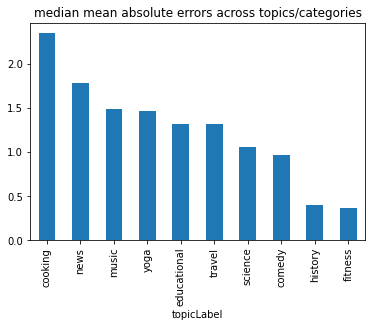

In [117]:
res_df.groupby('topicLabel')['diff'].agg('median').sort_values(ascending=False).plot(kind='bar')
plt.title("median mean absolute errors across topics/categories");

In [167]:
w2v_cols = ['title_'+str(i) for i in range(1, 51)]

In [166]:
test_X_[[w2v_cols[0]]+['topicLabel']].groupby('topicLabel').describe()

title_1                                                    \
              count      mean       std       min       25%       50%   
topicLabel                                                              
comedy       1007.0 -0.074306  0.164462 -0.557610 -0.186585 -0.094475   
cooking      1362.0 -0.070959  0.143145 -0.814060 -0.173812 -0.078839   
educational   990.0 -0.094075  0.128383 -0.493080 -0.186577 -0.103703   
fitness       926.0 -0.075305  0.152959 -0.557610 -0.159351 -0.087642   
history       768.0 -0.084423  0.129932 -0.943200 -0.155760 -0.094431   
music         692.0 -0.061454  0.154300 -0.462925 -0.158041 -0.082358   
news         1231.0 -0.096490  0.158808 -0.814060 -0.190977 -0.097350   
science       826.0 -0.087806  0.152203 -0.596605 -0.179610 -0.104834   
travel        846.0 -0.078890  0.146748 -0.661423 -0.179081 -0.081783   
yoga          974.0 -0.070618  0.129975 -0.493080 -0.150420 -0.082588   

                                 
                  75%       max  
topicLabel                       
comedy       0.014036  0.738330  
cooking      0.026794  0.379943  
educational -0.000613  0.441440  
fitness      0.003899  0.526690  
history     -0.016019  0.379943  
music        0.015937  0.406600  
news         0.004080  0.632510  
science     -0.000032  0.441440  
travel       0.012652  0.330722  
yoga        -0.016540  0.370893

In [225]:
pca = KernelPCA(n_components=1, kernel='poly', degree=5)
pca.fit(test_X_[w2v_cols])

KernelPCA(degree=5, kernel='poly', n_components=1)

In [205]:
x = pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])[:,0]
y = pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])[:,1]

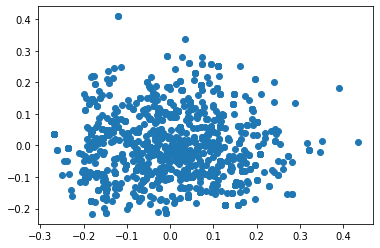

In [206]:
plt.scatter(x, y);

In [209]:
x = pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])[:,0]
y = pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])[:,1]

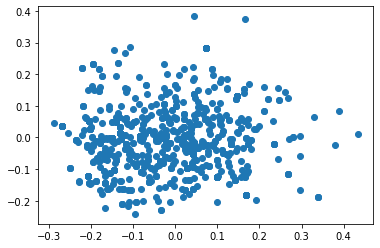

In [210]:
plt.scatter(x, y);

mean across labels With PC=1

In [226]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='cooking'][w2v_cols])).describe().loc['mean']

0    0.017089
Name: mean, dtype: float64

In [227]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='news'][w2v_cols])).describe().loc['mean']

0    0.030301
Name: mean, dtype: float64

In [230]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='music'][w2v_cols])).describe().loc['mean']

0   -0.038058
Name: mean, dtype: float64

In [231]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='yoga'][w2v_cols])).describe().loc['mean']

0    0.026005
Name: mean, dtype: float64

In [232]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='educational'][w2v_cols])).describe().loc['mean']

0   -0.001695
Name: mean, dtype: float64

In [233]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='travel'][w2v_cols])).describe().loc['mean']

0    0.035405
Name: mean, dtype: float64

In [234]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='science'][w2v_cols])).describe().loc['mean']

0   -0.027958
Name: mean, dtype: float64

In [228]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='fitness'][w2v_cols])).describe().loc['mean']

0   -0.035737
Name: mean, dtype: float64

In [229]:
pd.DataFrame(pca.transform(test_X_[test_X_.topicLabel=='history'][w2v_cols])).describe().loc['mean']

0    0.004801
Name: mean, dtype: float64

The above chart tells us that, across topics/categories, the model's performance is best for categories on the right(lower error is better) and worst on the left(higher error is worse)

In addition, We could also make a claim that selection of one of the categories amongst cooking, news, music would most likely throw the model farther away from the true value.

We'll try and validate the above claim with 3 values that visually show a large difference between the true an dpredicted value

In [118]:
static_sample = test_X[:60]

In [119]:
static_res_df = pd.DataFrame({'data_point#':list(np.arange(static_sample.shape[0])), 'true':list(test_y.values[:static_sample.shape[0]][:,0]), 'prediction':list(hgbr.predict(static_sample)[:static_sample.shape[0]])})

In [120]:
trace1 = go.Scatter(
    x=static_res_df["data_point#"],
    y=static_res_df['prediction'],
    name='prediction',
    mode='markers',
)
trace2 = go.Scatter(
    x=static_res_df["data_point#"],
    y=static_res_df['true'],
    name='true',
    mode='markers',

)

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=False)
fig['layout'].update(height = 600, width = 1300, title = "True vs predicted values closeness",xaxis=dict(
      tickangle=-55
    ))
fig

- From the above, Let's examine point #s 10, 19, 47 for the large errors and,
point #s 11, 23, 38 for their significantly small errors.
- (remember our hypothesis based on the above chart, points 10, 19, 47 are more likely to belong to groups on the left hand side of the barplot observed in the previous chart and points, 11, 23, 38 are more likely to belong to groups on the right)

In [127]:
test_X_.iloc[10].topicLabel, test_X_.iloc[19].topicLabel, test_X_.iloc[31].topicLabel

('cooking', 'cooking', 'news')

In [134]:
test_X_.iloc[11].topicLabel, test_X_.iloc[13].topicLabel, test_X_.iloc[38].topicLabel

('fitness', 'cooking', 'comedy')

- Our hypothesis does hold true in essence, as, the categoriesto the right seem to have predictions that are way off as compared to the ones on the left.
- An important observation to make note of is the ability of the cooking class to be really precise in some cases (like that of point #13). That brings us to the idea that it is likely that there could be more than just the underlying topicLabels that are responsible for throwing the prediction off.
- For the above reasons, let's take a closer look at the observations in the cooking category

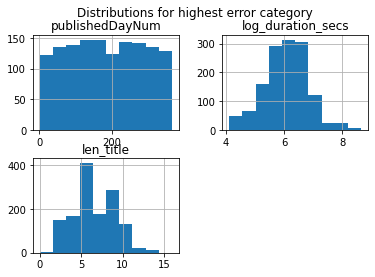

In [154]:
test_X_[test_X_.topicLabel=='cooking'][['publishedDayNum', 'log_duration_secs', 'len_title']].hist()
pl.suptitle("Distributions for highest error category");

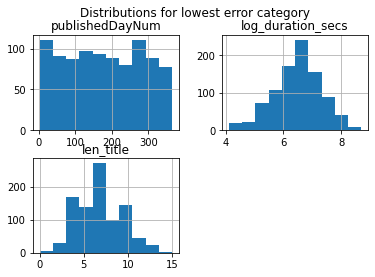

In [152]:
test_X_[test_X_.topicLabel=='fitness'][['publishedDayNum', 'log_duration_secs', 'len_title']].hist()
pl.suptitle("Distributions for lowest error category");

- A view into the distribution of these features, it is clear that there isn't an apparent difference that stands out amongst the best, worst performing topics/categories.
- Coupling this with the understanding that the definition contributed close to nothing <1% in the permutation importance stage, we are only left with the word vector representations as a possible explanation to the underlying problem.

Let's understand how the word vector representation could be the case.

- We incrementally, increased the complexity of the way we chose to do our title feature representation based on observed gains in performance. [count_vec->TFIDF->Word2Vec].
- While we note that the title, and the meta data available to us, don't really make an intuitive sense for these features being the at the core of the prediction of the title quality score.
There is a fundamental failure that prohibits the model from learning further without overfitting the training data:
  - The pre-trained word2vec model
  - It is easy to observe this from the analysis we carried out upto this point. i.e. we eliminated the possible involvement of other features as explained above.
  - The note we made above (from the bar chart) of the labels on the left, like `cooking` being markers of possibilities of high error predictions sheds light on what the shortcomings of the pretrained model could be. i.e. under the topic `cooking` the titles are more likely to use names of newer receipes, words that don't strictly obey the language construct and hence have a lot of OOV words. (The pretrained model we used is that of a smaller generic wikipedia representation). linearity shoudn't be a problem because w2v models are very good at capturing high dimensional feature space info in a relatively smaller dimension space.
  - Categories like `fitness`, `history` tend to have words that are similar across variations e.g. "abs and core workout", "strengthen your core muscles", etc while categories like music seem to use more uniqueness in naming.
    1. To address the above failure, we'd have to pick a larger pretrained model that is ideally specific to the categories/topics.
    2. Another approach could be that of increasing the data from ~5.5k per topic/category to atleast 55k per category and then training a custom w2v model.
    3. To address varaiations, the bar chart we obtained could be a good point of start to obtain additional data based inversely proportional to the error rates, implying that we would as a result, be able to help the model justify variations instead of the model trying to overfit what now, would look like noise.

As things currently stand, the model would fail if the data that is fairly recent (newer `news`/`music`(song names)) and was not a part of the tranining of the pretrained model.
Since this accounts for ~53% of the model's explainability, this adjustment would definitely help mitigate the kind of failures we observed.